# Description 


**Author**: Felipe Matheus <br>
**Start Date**: 07/06/2022 <br>

# Index

1. Index
1. Setup
1. Load data & models
1. Plotting

# Setup

Libs

In [1]:
import os
import re
import sys
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Modules

In [2]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing.Processing import Processing
from src.visualization.Plots import Plots
from src.modeling.Seed import Seed
from src.DataLoader import DataLoader
from src.feature_engineering.FeatureEngineering import FeatureEngineering
from config.Variables import Variables
from src.metrics.Metrics import Metrics

feng = FeatureEngineering()
varv = Variables()
plot = Plots()
proc = Processing()
mtrc = Metrics()
load_struct =  DataLoader(varv.STRUCTURED_DATA_PATH)
load_models = DataLoader(varv.MODELS_PATH)
load_data_plots = DataLoader("../../data/plots/")
seed = Seed(81)

MIX_PROPORTION = (
    0.099,
    0.229,
    0.128,
    0.083,
    0.224,
    0.237,
)

# Load data

In [3]:
load_models = DataLoader(varv.MODELS_PATH)
# Values
values_nd = np.load(f"{varv.STRUCTURED_DATA_PATH}spec_train_2_6sources_no_decalibration_no_bdf.npy")
labels_nd = np.load(f"{varv.STRUCTURED_DATA_PATH}yprop_train_2_6sources_no_decalibration_no_bdf.npy")
# Attenuation
attenuation = np.load(f"{varv.STRUCTURED_DATA_PATH}att_proba.npy")
attenuation_labels = np.load(f"{varv.STRUCTURED_DATA_PATH}att_labels.npy")
# GANs
models = {model: tf.keras.models.load_model(model_path)
          for model_path, model in zip(load_models.files_path, load_models.files)}
keys = load_models.files
# GNNs
gnn_model = tf.keras.models.load_model(f"{varv.MODELS_PATH}supervised_model.hdf5")
# jeff_am = np.load("../../data/plots/Jeff_Am_no_attenuation.npy")
# jeff_mix = np.load("../../data/plots/Jeff_Arbitrary_mix_no_attenuation.npy")
# jeff_att = np.load("../../data/plots/Jeff_Cs_Eu_aluminium.npy")

# Generate samples

## MC data

MC single elements

In [4]:
mc_samples = proc.get_sample_of_each_element(values_nd, labels_nd)
mc_single_elements = {k: v/np.sum(v,keepdims=True) for k, v in mc_samples.items()}

MC single elements attenuated

In [5]:
mc_single_elements_att = {
    f"{k}_att": np.multiply(v/np.max(v, keepdims=True), attenuation[1]) for k, v in mc_samples.items()
}
mc_single_elements_att = {
    k: v/np.sum(v, keepdims=True) for k, v in mc_single_elements_att.items()
}

MC mixed 

In [6]:
mc_mix = 0
for elem, prop in zip(mc_samples.values(), MIX_PROPORTION):
    mc_mix += elem*prop
mc_mix = mc_mix/np.sum(mc_mix, keepdims=True)

MC attenuated

In [7]:
mc_att = mc_samples["Cs"]*0.3 + mc_samples["Eu"]*0.7
mc_att = mc_att/np.max(mc_att, keepdims=True)
mc_att = np.multiply(mc_att, attenuation[1])
mc_att = mc_att/np.sum(mc_att, keepdims=True)
assert math.isclose(sum(mc_att),  1)

## GNNs

Single elements

In [8]:
gnn_single_elements = {}
for i, elem in enumerate(mc_samples):
    one_hot = [0, 0, 0, 0, 0, 0, 0]
    one_hot[i] = 1
    gnn_single_elements[elem] = gnn_model(tf.constant(one_hot, shape=(1, 7))).numpy().squeeze()


Attenuated single elements

In [9]:
gnn_single_elements_att = {
    f"{k}_att": np.multiply(v/np.max(v, keepdims=True), attenuation[1]) for k, v in gnn_single_elements.items()
}
gnn_single_elements_att = {
    k: v/np.sum(v, keepdims=True) for k, v in gnn_single_elements_att.items()
}

Mixed

In [10]:
gnn_mix = gnn_model(tf.constant(list(MIX_PROPORTION)+[0], shape=(1, 7))).numpy().squeeze()

Attenuated mixed

In [11]:
gnn_att = gnn_model(
    tf.constant(
        [0, 0, 0, 0.3, 0.7, 0, attenuation_labels[1].squeeze()],
        shape=(1, 7))).numpy().squeeze()


## GAN

In [12]:
# _model =  models["CSGAN_critic_even_stronger_more_data_generator_epoch10.hdf5"]
# _model =  models["generator_poster.hdf5"]
# _model =  models["csgan_no_decalibration_generator_epoch20.hdf5"]
_model =  models["csgan_no_decalibration_generator_epoch98.hdf5"]

Single elements

In [13]:
gan_single_elements = {}
for i, elem in enumerate(mc_single_elements):
    one_hot = [0, 0, 0, 0, 0, 0, 0]
    one_hot[i] = 1
    seed_high_stat = seed.get_concat_noise_with_label(
        labels=np.array([one_hot for _ in range(10000)])
    )
    gan_single_elements[elem] = _model(seed_high_stat)[:, :, 0].numpy()
    gan_single_elements[elem] = gan_single_elements[elem]/np.sum(gan_single_elements[elem],
                                                                 axis=1, keepdims=True)
    gan_single_elements[elem] = np.mean(gan_single_elements[elem], axis=0)


In [21]:
import random
np.append(np.random.dirichlet(np.ones(6),size=2), random.uniform(0.5, 10))

array([0.14433303, 0.30797086, 0.10259471, 0.195561  , 0.17732911,
       0.07221128, 0.14217578, 0.02559338, 0.04614866, 0.44521544,
       0.30817292, 0.03269382, 5.80072285])

# New and last time generation

## SGN

In [35]:
n_spec = 100
s = np.concatenate([
    np.random.dirichlet(np.ones(6),size=n_spec), np.random.uniform(low=0.5, high=10, size=(n_spec,1))
], axis=1)
start_time = time.time()
gnn_model(s).numpy().squeeze()
t = time.time()
print(t-start_time)

## GAN

In [58]:
n_spec = 100000
s = np.concatenate([
    np.random.dirichlet(np.ones(6),size=n_spec), np.random.uniform(low=0.5, high=10, size=(n_spec,1))
], axis=1)
z = np.random.normal(size=(n_spec,64))
s_gan = np.concatenate([
    z, s
],axis=1)
s_gan = np.reshape(s_gan, (n_spec, 1, s_gan.shape[-1]))

In [59]:
start_time = time.time()
_model(s_gan).numpy()
t = time.time()
print(t-start_time)

ResourceExhaustedError: Exception encountered when calling layer "conv1d_transpose_2" (type Conv1DTranspose).

OOM when allocating tensor with shape[100000,128,1,142] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

Call arguments received:
  • inputs=tf.Tensor(shape=(100000, 142, 128), dtype=float32)

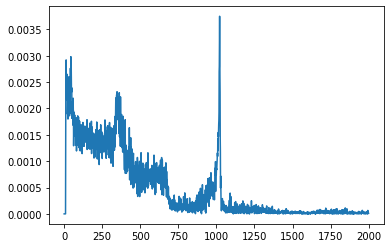

In [14]:
plt.plot(gan_single_elements["Na"])

Single elements attenuated

In [15]:
gan_single_elements_att = {}
for i, elem in enumerate(mc_single_elements_att):
    one_hot = [0, 0, 0, 0, 0, 0, attenuation_labels[1]]
    one_hot[i] = 1
    seed_high_stat = seed.get_concat_noise_with_label(
        labels=np.array([one_hot for _ in range(10000)])
    )
    gan_single_elements_att[elem] = _model(seed_high_stat)[:, :, 0].numpy()
    gan_single_elements_att[elem] = gan_single_elements_att[elem]/np.sum(gan_single_elements_att[elem],
                                                                 axis=1, keepdims=True)
    gan_single_elements_att[elem] = np.mean(gan_single_elements_att[elem], axis=0)


C:\Users\ff268477\AppData\Local\Temp\ipykernel_18084\3939728994.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels=np.array([one_hot for _ in range(10000)])


Random mix

In [35]:
# High Statistic
shs = seed.get_concat_noise_with_label(
    labels=np.array(
        [[0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0] for i in range(10000)]
    ),
    std=1
)
gan_mix = _model(shs)[:,:,0].numpy()
gan_mix = gan_mix/np.sum(gan_mix, axis=1, keepdims=True)
gan_mix = np.mean(gan_mix, axis=0)

In [36]:
gan_mix.shape

(2000,)

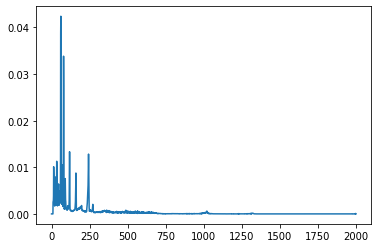

In [37]:
plt.plot(gan_mix)

Attenuated

In [17]:
# High Statistic
shs = seed.get_concat_noise_with_label(
    labels=np.array(
        [[0, 0, 0, 0.3, 0.7, 0, attenuation_labels[1].squeeze()] for i in range(10000)]
    ),
    std=1
)
gan_att = _model(shs)[:,:,0].numpy()
gan_att = gan_att/np.sum(gan_att, axis=1, keepdims=True)
gan_att = np.mean(gan_att, axis=0)

# Prepare comparisons

In [18]:
results = {
    "GAN": {
        **gan_single_elements,
        **gan_single_elements_att,
        "Mix": gan_mix,
        "Att": gan_att,
    },
    "MC": {
        **mc_single_elements,
        **mc_single_elements_att,
        "Mix": mc_mix,
        "Att": mc_att
    },
    "GNN": {
        **gnn_single_elements,
        **gnn_single_elements_att,
        "Mix": gnn_mix,
        "Att": gnn_att,
    }
}

# Chi square evaluation

In [19]:
worst_case = np.ones(shape=len(results["GNN"]["Am"]))*(1/len(results["GNN"]["Am"]))

In [20]:
categories = results["MC"].keys()
methods = ["GNN", "GAN"]
chi2_evaluation_norm = {
    (mod, cat): mtrc.chi2_distance_normalized(results["MC"][cat], results[mod][cat]) for mod in methods for cat in categories 
}

chi2_evaluation_norm

{('GNN', 'Am'): (0.0001, 1.8136),
 ('GNN', 'Ba'): (0.0003, 1.6378),
 ('GNN', 'Co'): (0.0003, 1.6101),
 ('GNN', 'Cs'): (0.0006, 1.0757),
 ('GNN', 'Eu'): (0.0006, 1.5274),
 ('GNN', 'Na'): (0.0009, 0.719),
 ('GNN', 'Am_att'): (0.0003, 1.9289),
 ('GNN', 'Ba_att'): (0.0014, 1.3067),
 ('GNN', 'Co_att'): (0.0003, 1.7679),
 ('GNN', 'Cs_att'): (0.0013, 0.7256),
 ('GNN', 'Eu_att'): (0.0091, 0.8679),
 ('GNN', 'Na_att'): (0.0024, 0.5926),
 ('GNN', 'Mix'): (0.0008, 1.1542),
 ('GNN', 'Att'): (0.0169, 0.6884),
 ('GAN', 'Am'): (0.0026, 1.8136),
 ('GAN', 'Ba'): (0.0307, 1.6378),
 ('GAN', 'Co'): (0.0092, 1.6101),
 ('GAN', 'Cs'): (0.0974, 1.0757),
 ('GAN', 'Eu'): (0.0346, 1.5274),
 ('GAN', 'Na'): (0.0152, 0.719),
 ('GAN', 'Am_att'): (0.0072, 1.9289),
 ('GAN', 'Ba_att'): (0.4004, 1.3067),
 ('GAN', 'Co_att'): (0.0569, 1.7679),
 ('GAN', 'Cs_att'): (0.0179, 0.7256),
 ('GAN', 'Eu_att'): (0.3177, 0.8679),
 ('GAN', 'Na_att'): (0.0626, 0.5926),
 ('GAN', 'Mix'): (0.0165, 1.1542),
 ('GAN', 'Att'): (0.1348, 0.6884)

In [21]:
categories = results["MC"].keys()
methods = ["GNN", "GAN"]
chi2_evaluation = {
    (mod, cat): mtrc.chi2_distance(results["MC"][cat], results[mod][cat]) for mod in methods for cat in categories 
}

chi2_evaluation

{('GNN', 'Am'): 0.0002,
 ('GNN', 'Ba'): 0.0004,
 ('GNN', 'Co'): 0.0005,
 ('GNN', 'Cs'): 0.0007,
 ('GNN', 'Eu'): 0.0009,
 ('GNN', 'Na'): 0.0006,
 ('GNN', 'Am_att'): 0.0005,
 ('GNN', 'Ba_att'): 0.0019,
 ('GNN', 'Co_att'): 0.0005,
 ('GNN', 'Cs_att'): 0.001,
 ('GNN', 'Eu_att'): 0.0079,
 ('GNN', 'Na_att'): 0.0014,
 ('GNN', 'Mix'): 0.0009,
 ('GNN', 'Att'): 0.0117,
 ('GAN', 'Am'): 0.0047,
 ('GAN', 'Ba'): 0.0503,
 ('GAN', 'Co'): 0.0148,
 ('GAN', 'Cs'): 0.1048,
 ('GAN', 'Eu'): 0.0529,
 ('GAN', 'Na'): 0.011,
 ('GAN', 'Am_att'): 0.014,
 ('GAN', 'Ba_att'): 0.5233,
 ('GAN', 'Co_att'): 0.1007,
 ('GAN', 'Cs_att'): 0.013,
 ('GAN', 'Eu_att'): 0.2758,
 ('GAN', 'Na_att'): 0.0371,
 ('GAN', 'Mix'): 0.019,
 ('GAN', 'Att'): 0.0928}

# Plots

In [22]:
def prepare_box(ax, proportions, box_positions):
    elements = ["$^{241}$Am","$^{133}$Ba","$^{57}$Co","$^{137}$Cs","$^{152}$Eu","$^{22}$Na","$^{27}$Al"]
    s = "Elements proportions: "
    for i in range(len(proportions)-1):
        s += "\n"+elements[i]+": "+str(np.round(proportions[i]*100,1)) + " %"

    if proportions[-1] != 0: 
        s += "\nAttenuation: "
        s += "\n"+elements[-1]+": "+str(proportions[-1]) + "cm"

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(box_positions[0], box_positions[1], s, transform=ax.transAxes, fontsize=11.5,
            verticalalignment='top', bbox=props)

In [23]:
def prepare_box_chi2(ax, chi2d_values, box_positions):
    s = "Normalized Chi2 distance: "
    for val in chi2d_values:
        s += str(val)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    ax.text(box_positions[0], box_positions[1], s, transform=ax.transAxes, fontsize=11.5,
            verticalalignment='top', bbox=props)

In [24]:
ms = ['GAN', 'MC', 'GNN']
ss = ["Am", "Mix", "Att"]

colors = ["blue", "red", "green"]
x_limits = [125, 1000, 1000]
y_limits = [0, 5e-5, 5e-5]
scales = ["linear", "log", "log"]
box_positions = [(0.745, 0.96), (0.745, 0.96), (0.745, 0.96)]
box_chi2d_positions = [(0.545, 0.96), (0.545, 0.96), (0.545, 0.96)]

proportions = [
    [1, 0, 0, 0., 0, 0, 0],
    [0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0],
    [0, 0, 0, 0.3, 0.7, 0, 6.17]
]

chi2d_values = [
    [0.0026, 0.0165, 0.1348],
    [0, 0, 0],
    [0.0001, 0.0008,  0.0169]
]
chi2d_values_t = {
    ('GNN', 'Am'): 0.0001,
    ('GNN', 'Mix'): 0.0008,
    ('GNN', 'Att'): 0.0169,
    ('GAN', 'Am'): 0.0026,
    ('GAN', 'Mix'): 0.0165,
    ('GAN', 'Att'): 0.1348
}


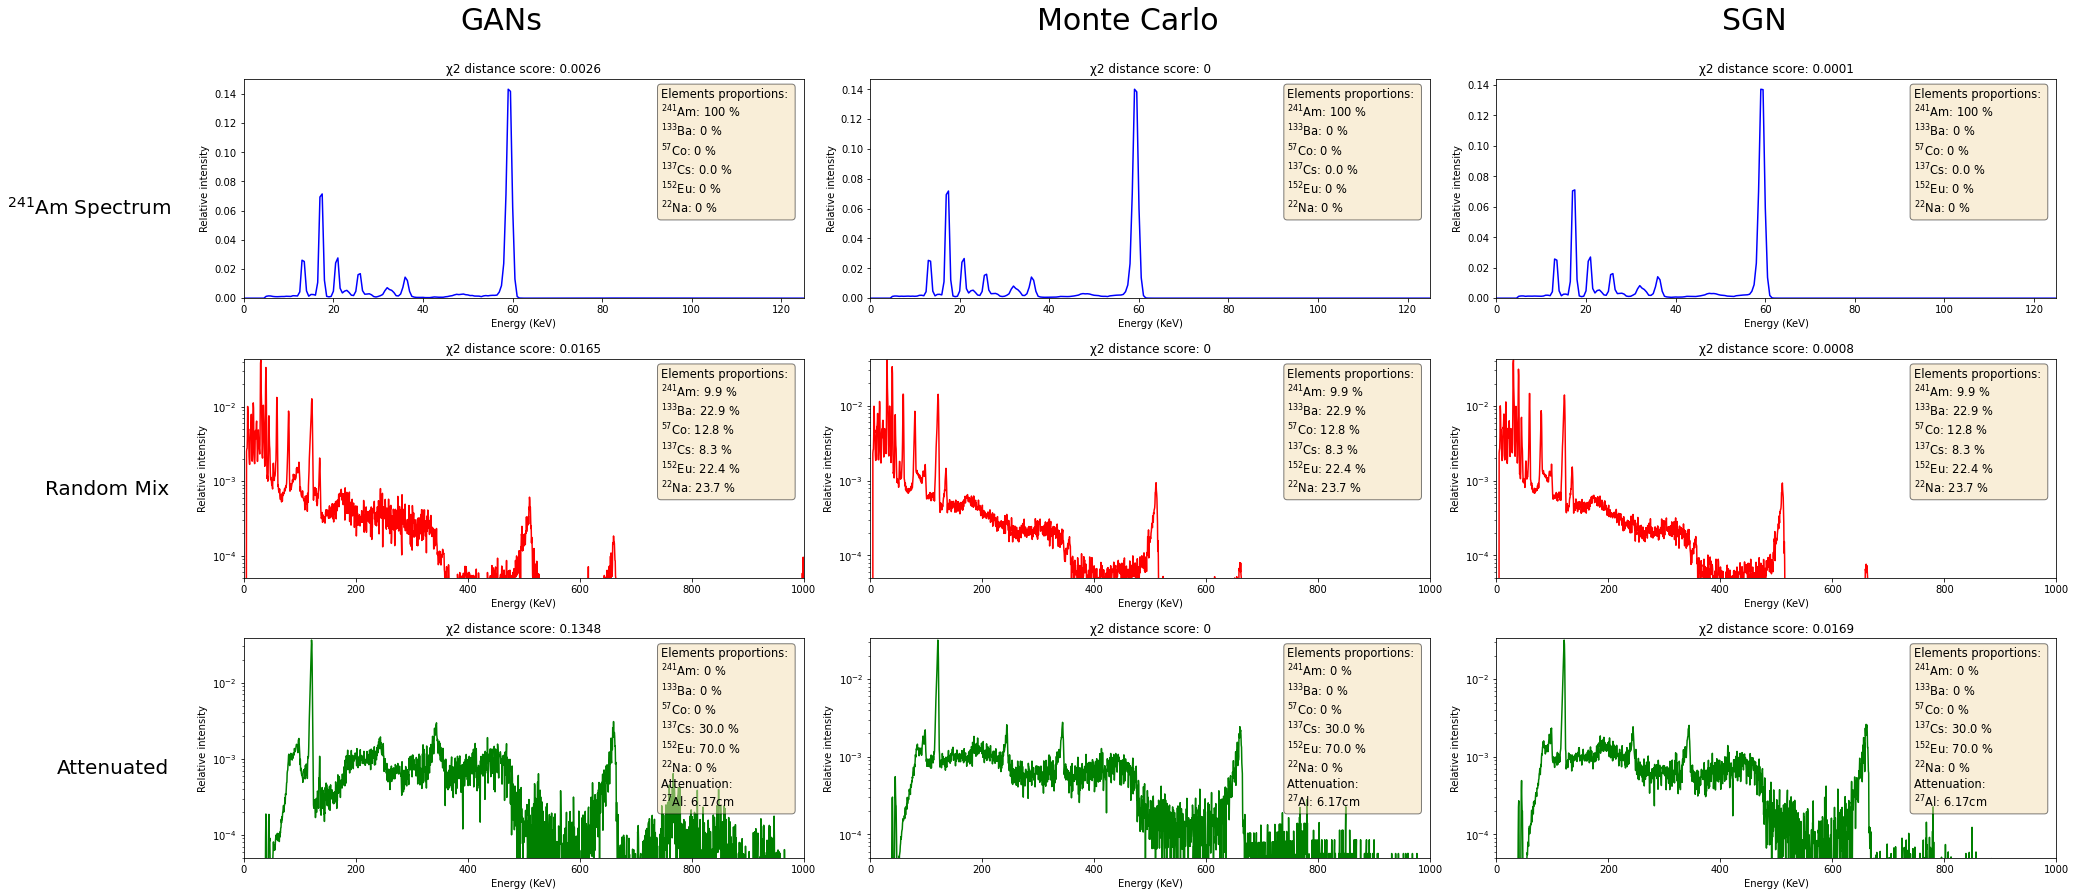

In [46]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy


cols = ["GANs", "Monte Carlo", "SGN"]
# rows = ["Am Spectrum", "Random Mix", f"""30% of Cs,
# 70% of Eu
# behind
#     6.17cm of Al"""]
# rows = [""]*3
rows = ["$^{241}$Am Spectrum", "Random Mix", "Attenuated"]

fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(30, 12),
    gridspec_kw=dict(width_ratios=[1., 1., 1.])
)
plt.setp(axes.flat, xlabel='Energy (KeV)', ylabel='Relative intensity')


pad = 5  # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.46, 1.2), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=30, ha='center', va='baseline')

for ax, row in zip(axes[:, 0], rows):
    if len(row) > 20:
        ax.annotate(row, xy=(-2, -1), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=20, ha='right', va='baseline', rotation=0)
    else:
        ax.annotate(row, xy=(-2, 0.2), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    fontsize=20, ha='right', va='baseline', rotation=0)

for i, method in enumerate(ms):
    for j, simulation in enumerate(ss):
        axes[j][i].plot(
            np.linspace(0, 1000, 2000),
            results[method][simulation],
            color=colors[j],
        )
        # Limit
        axes[j][i].set_xlim([0, x_limits[j]])
        axes[j][i].set_ylim([y_limits[j], None])
        axes[j][i].set_title(f"\u03C72 distance score: {chi2d_values[i][j]}")
        # Notes
        prepare_box(axes[j][i], proportions[j], box_positions[j])
        # if method != "MC":
        # s = "Normalized Chi2 distance: " + str(chi2d_values[j][i])
        # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # axes[j][i].text(box_chi2d_positions[j][0], box_chi2d_positions[j][1], s, transform=ax.transAxes, fontsize=11.5,
        #                 verticalalignment='top', bbox=props)
        # Scale
        axes[j][i].set_yscale(scales[j])


fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need
# to make some room. These numbers are are manually tweaked.
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)
plt.savefig('results.pdf', bbox_inches='tight')


# Real Am detection

In [26]:
load_am = DataLoader(varv.RAW_DATA_PATH+"fits/")
fits = load_am.load_fits(remove_na=False)
energies = proc.get_energy_dict(fits)

In [27]:
spectre, bins = np.histogram(
                energies["am"], range=(0, 6000), bins=12000)


In [28]:
am_real =  spectre/np.sum(spectre)

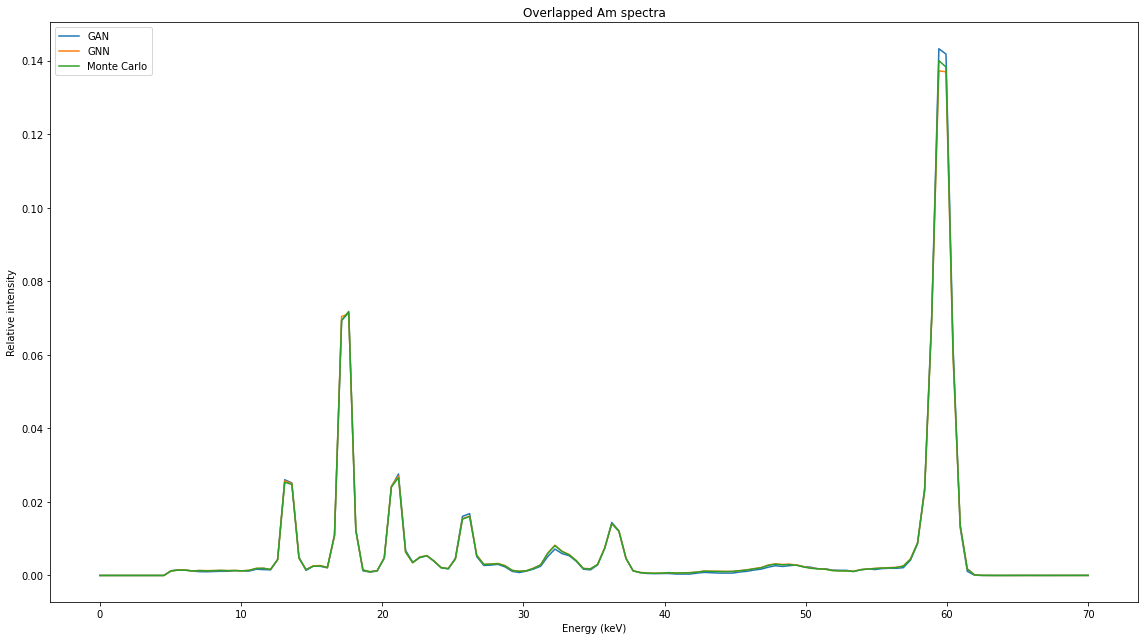

In [29]:
plt.figure(figsize=(16, 9))
plt.title("Overlapped Am spectra")


plt.plot(np.linspace(0,70,140), results["GAN"]["Am"][:140], label="GAN")
# plt.plot(np.linspace(0,70,140), am_real[:140], label="Real")
plt.plot(np.linspace(0,70,140), results["GNN"]["Am"][:140], label="GNN")
plt.plot(np.linspace(0,70,140), results["MC"]["Am"][:140], label="Monte Carlo")

plt.ylabel("Relative intensity")
plt.xlabel("Energy (keV)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('Americium Overlapped.pdf', bbox_inches='tight')

# Time evaluation

## GAN

100000 photons

In [30]:
gan_time = {}
n_spectra_values = (100,1000)
for n_spectra in n_spectra_values:

    # Single elements
    for i, elem in enumerate(mc_single_elements):
        one_hot = [0, 0, 0, 0, 0, 0, 0]
        one_hot[i] = 1
        seed_high_stat = seed.get_concat_noise_with_label(
            labels=np.array([one_hot for _ in range(n_spectra)], dtype=object)
        )
        start_time = time.time()

        sim = _model(seed_high_stat)[:, :, 0].numpy()
        sim_norm = sim/np.sum(sim, axis=1, keepdims=True)

        t = time.time() - start_time
        gan_time[(n_spectra, elem)] = t

    # Single elements atte
    for i, elem in enumerate(mc_single_elements_att):
        one_hot = [0, 0, 0, 0, 0, 0, attenuation_labels[1]]
        one_hot[i] = 1
        seed_high_stat = seed.get_concat_noise_with_label(
            labels=np.array([one_hot for _ in range(n_spectra)], dtype=object)
        )
        start_time = time.time()
        
        sim = _model(seed_high_stat)[:, :, 0].numpy()
        sim = sim/np.sum(sim, axis=1, keepdims=True)

        t = time.time() - start_time
        gan_time[(n_spectra, elem)] = t

    # Mixture
    shs = seed.get_concat_noise_with_label(
        labels=np.array(
            [[0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0] for i in range(n_spectra)]
        ),
        std=1
    )
    start_time = time.time()

    gan_mix = _model(shs)[:,:,0].numpy()
    gan_mix = gan_mix/np.sum(gan_mix, axis=1, keepdims=True)

    t = time.time() - start_time
    gan_time[(n_spectra, "mix")] = t

    # Attenuated
    shs = seed.get_concat_noise_with_label(
        labels=np.array(
            [[0, 0, 0, 0.3, 0.7, 0, attenuation_labels[1].squeeze()] for i in range(n_spectra)]
        ),
        std=1
    )
    start_time = time.time()

    gan_att = _model(shs)[:,:,0].numpy()
    gan_att = gan_att/np.sum(gan_att, axis=1, keepdims=True)

    t = time.time() - start_time
    gan_time[(n_spectra, "att")] = t


In [31]:
gan_time


{(100, 'Am'): 0.32959628105163574,
 (100, 'Ba'): 0.012999534606933594,
 (100, 'Co'): 0.011996746063232422,
 (100, 'Cs'): 0.02200150489807129,
 (100, 'Eu'): 0.017003774642944336,
 (100, 'Na'): 0.013005495071411133,
 (100, 'Am_att'): 0.011004209518432617,
 (100, 'Ba_att'): 0.01099395751953125,
 (100, 'Co_att'): 0.012000799179077148,
 (100, 'Cs_att'): 0.023993253707885742,
 (100, 'Eu_att'): 0.011992454528808594,
 (100, 'Na_att'): 0.010993480682373047,
 (100, 'mix'): 0.025001049041748047,
 (100, 'att'): 0.02000141143798828,
 (1000, 'Am'): 0.530876874923706,
 (1000, 'Ba'): 0.08199787139892578,
 (1000, 'Co'): 0.07999563217163086,
 (1000, 'Cs'): 0.0791170597076416,
 (1000, 'Eu'): 0.08116650581359863,
 (1000, 'Na'): 0.08700132369995117,
 (1000, 'Am_att'): 0.08935308456420898,
 (1000, 'Ba_att'): 0.08599424362182617,
 (1000, 'Co_att'): 0.09236979484558105,
 (1000, 'Cs_att'): 0.0910642147064209,
 (1000, 'Eu_att'): 0.0872809886932373,
 (1000, 'Na_att'): 0.08999776840209961,
 (1000, 'mix'): 0.08100

## GANs with sortage

In [32]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [42]:
int_spec.shape

(1000, 2000)

In [43]:
import time
gan_time_sortage = {}
n_spectra_values = (100, 1000, 10000)
n_photons = 100000

for n_spectra in n_spectra_values:
    start_time = time.time()

    shs = seed.get_concat_noise_with_label(
        labels=np.array(
            [[0.099, 0.229, 0.128, 0.083, 0.224, 0.237, 0] for i in range(10000)]
        ),
        std=1
    )
    gan_mix = _model(shs)[:,:,0].numpy()
    gan_mix = gan_mix/np.sum(gan_mix, axis=1, keepdims=True)
    gan_mix = np.mean(gan_mix, axis=0)
    int_spec = np.round(gan_mix*n_photons).astype(int)
    sample = proc.get_reverse_histogram(int_spec)

    ans = feng.gen_random_samples_bin(photons_kev_array_value=sample,
                                    amount_samples=n_spectra,
                                    amount_photons=n_photons)
    t = time.time() - start_time
    gan_time_sortage[n_spectra] = t


# for n_spectra in n_spectra_values:

#     # Single elements
#     for i, elem in enumerate(mc_single_elements):
#         one_hot = [0, 0, 0, 0, 0, 0, 0]
#         one_hot[i] = 1
#         seed_high_stat = seed.get_concat_noise_with_label(
#             labels=np.array([one_hot for _ in range(n_spectra)], dtype=object)
#         )
        
#         sim = _model(seed_high_stat)[:, :, 0].numpy()
#         sim = np.mean(sim, axis=0, keepdims=True)
#         sim_norm = sim/np.sum(sim, axis=1, keepdims=True)
#         start_time = time.time()
#         # random sorting
#         int_spec = np.round(sim_norm*n_photons).astype(int)
#         sample = proc.get_reverse_histogram(int_spec)
#         ans = feng.gen_random_samples_bin(photons_kev_array_value=sample,
#                                           amount_samples=n_spectra,
#                                           amount_photons=n_photons)

#         t = time.time() - start_time
#         gan_time_sortage[(n_spectra, elem)] = t



In [44]:
gan_time_sortage

{100: 1.6222269535064697, 1000: 5.4069952964782715, 10000: 47.5287070274353}

## GNNs

In [ ]:
import time

gnn_time = {}
n_photons = 100000
n_spectra_values = (100, 1000, 10000)
# Multiplicar, arredondar e dair pegar o random samples e normalizar
for key, value in results["GNN"].items():
    int_spec = np.round(value*n_photons).astype(int)
    for n_spectra in n_spectra_values:
        start_time = time.time()
        sample = proc.get_reverse_histogram(int_spec)
        ans = feng.gen_random_samples_bin(photons_kev_array_value=sample,
                                          amount_samples=n_spectra,
                                          amount_photons=n_photons)
        t = time.time() - start_time
        gnn_time[(n_spectra, key)] = t


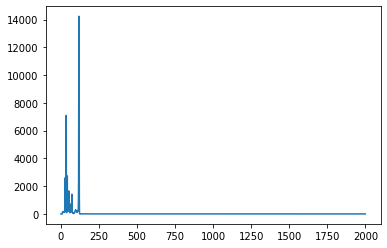

In [ ]:
plt.plot(int_spec[0])

In [ ]:
gnn_time

{(100, 'Am'): 0.5717885494232178,
 (1000, 'Am'): 4.895433664321899,
 (10000, 'Am'): 48.765392541885376,
 (100, 'Ba'): 0.5795152187347412,
 (1000, 'Ba'): 5.006347894668579,
 (10000, 'Ba'): 51.555891275405884,
 (100, 'Co'): 0.5262258052825928,
 (1000, 'Co'): 4.938868284225464,
 (10000, 'Co'): 49.818727016448975,
 (100, 'Cs'): 0.4216125011444092,
 (1000, 'Cs'): 4.905071020126343,
 (10000, 'Cs'): 50.71758818626404,
 (100, 'Eu'): 0.3643012046813965,
 (1000, 'Eu'): 4.662826776504517,
 (10000, 'Eu'): 47.786787271499634,
 (100, 'Na'): 0.5348784923553467,
 (1000, 'Na'): 4.947386741638184,
 (10000, 'Na'): 50.06062150001526,
 (100, 'Am_att'): 0.39084482192993164,
 (1000, 'Am_att'): 4.8483827114105225,
 (10000, 'Am_att'): 49.46444272994995,
 (100, 'Ba_att'): 0.6304268836975098,
 (1000, 'Ba_att'): 4.4169816970825195,
 (10000, 'Ba_att'): 50.194453716278076,
 (100, 'Co_att'): 0.5749964714050293,
 (1000, 'Co_att'): 5.350854873657227,
 (10000, 'Co_att'): 51.162654638290405,
 (100, 'Cs_att'): 0.57742381

In [ ]:
gan_time_sortage

{}

In [ ]:
sample

array([ 38.5,  38.5,  39. , ..., 992. , 992.5, 994. ])

In [ ]:
gnn_time

{(100, 'Am'): 0.5717885494232178,
 (1000, 'Am'): 4.895433664321899,
 (10000, 'Am'): 48.765392541885376,
 (100, 'Ba'): 0.5795152187347412,
 (1000, 'Ba'): 5.006347894668579,
 (10000, 'Ba'): 51.555891275405884,
 (100, 'Co'): 0.5262258052825928,
 (1000, 'Co'): 4.938868284225464,
 (10000, 'Co'): 49.818727016448975,
 (100, 'Cs'): 0.4216125011444092,
 (1000, 'Cs'): 4.905071020126343,
 (10000, 'Cs'): 50.71758818626404,
 (100, 'Eu'): 0.3643012046813965,
 (1000, 'Eu'): 4.662826776504517,
 (10000, 'Eu'): 47.786787271499634,
 (100, 'Na'): 0.5348784923553467,
 (1000, 'Na'): 4.947386741638184,
 (10000, 'Na'): 50.06062150001526,
 (100, 'Am_att'): 0.39084482192993164,
 (1000, 'Am_att'): 4.8483827114105225,
 (10000, 'Am_att'): 49.46444272994995,
 (100, 'Ba_att'): 0.6304268836975098,
 (1000, 'Ba_att'): 4.4169816970825195,
 (10000, 'Ba_att'): 50.194453716278076,
 (100, 'Co_att'): 0.5749964714050293,
 (1000, 'Co_att'): 5.350854873657227,
 (10000, 'Co_att'): 51.162654638290405,
 (100, 'Cs_att'): 0.57742381